### `DemandSupplySimulation` 環境設定方法

<p>Click to copy each command:</p>

1. **Open Terminal**  
   - Click on `Terminal` -> `New Terminal`

2. **Run Environment Creation Command**
   - Command: `conda env create -f environment.yml`  
     <button onclick="navigator.clipboard.writeText('conda env create -f environment.yml')">Copy Command</button>

3. **Update Existing Environment**  
   - Command: `conda env update -f environment.yml --prune`  
     <button onclick="navigator.clipboard.writeText('conda env update -f environment.yml --prune')">Copy Command</button>

4. **If `conda` is Not Available**  
   - Install conda mini.

### Frequently Used Commands
1. **List Existing Environment**  
   - Command: `conda env list`  
     <button onclick="navigator.clipboard.writeText('conda env list')">Copy Command</button>

# 投資最適化計算


年次: 2024年の最適化を開始


INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
最適化を実行中... (需要変化率: 0%)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
INFO:linopy.io: Writing time: 4.93s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 244825 primals, 870084 duals
Objective: 2.00e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance, Link-ramp_limit_up, Link-ramp_limit_down were not assigned to the network.


✓ 2024年の最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2024.nc contains: generators, buses, loads, carriers, links, sub_networks, stores
c:\Users\takashi-yanase\AppData\Local\miniconda3\envs\pypsa_tepsco\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



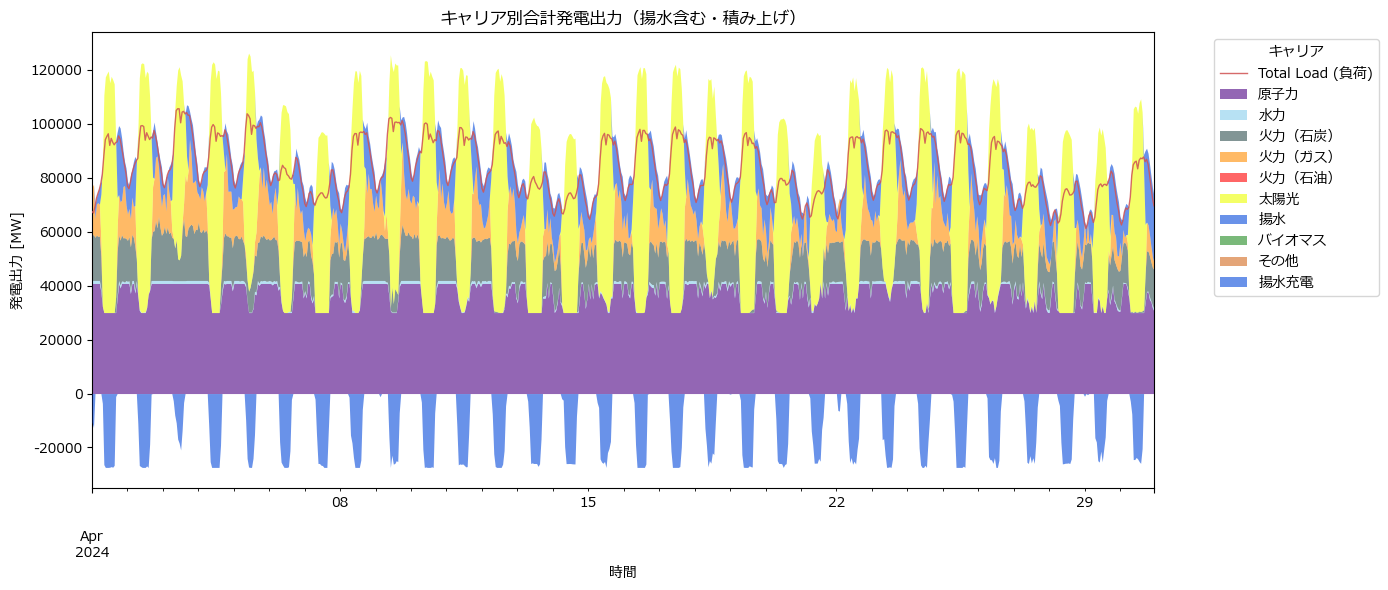


年次: 2030年の最適化を開始


INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
最適化を実行中... (需要変化率: 10%)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:linopy.io: Writing time: 4.95s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 244825 primals, 870084 duals
Objective: 4.03e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance, Link-ramp_limit_up, Link-ramp_limit_down were not assigned to the network.


✓ 2030年の最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2030.nc contains: generators, buses, loads, carriers, links, sub_networks, stores
c:\Users\takashi-yanase\AppData\Local\miniconda3\envs\pypsa_tepsco\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



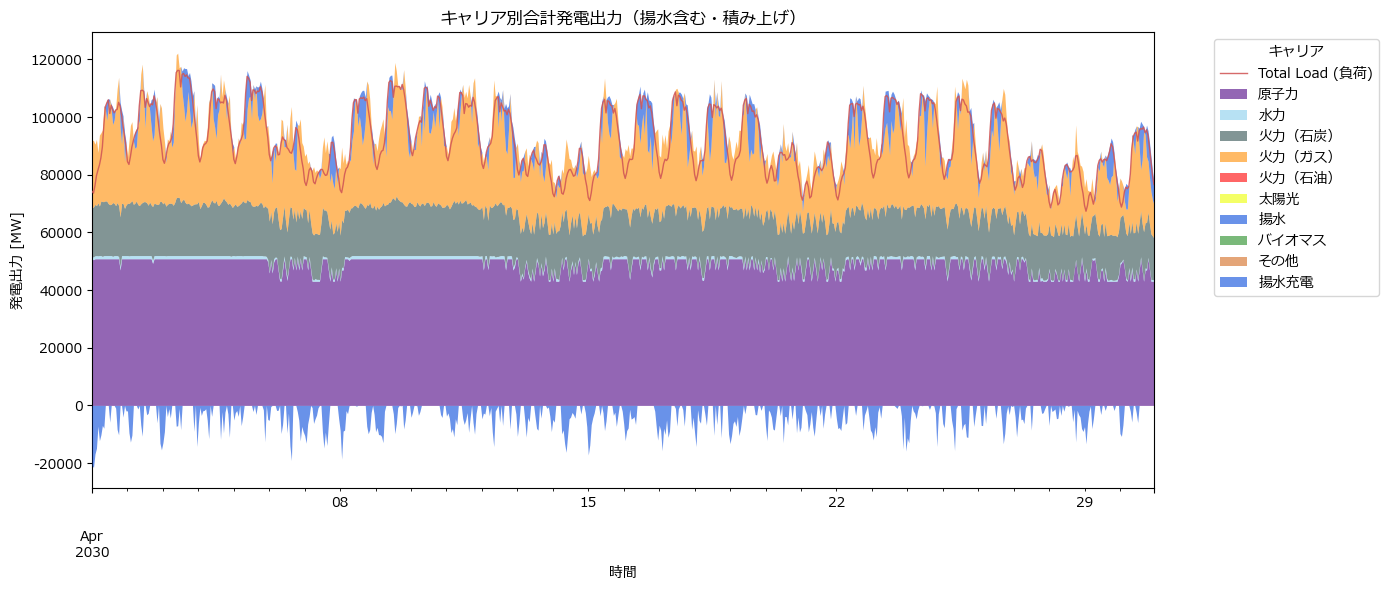


年次: 2040年の最適化を開始


INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
最適化を実行中... (需要変化率: 20%)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 13.16it/s]
INFO:linopy.io: Writing time: 4.75s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 244825 primals, 870084 duals
Objective: 4.50e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance, Link-ramp_limit_up, Link-ramp_limit_down were not assigned to the network.


✓ 2040年の最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2040.nc contains: generators, buses, loads, carriers, links, sub_networks, stores
c:\Users\takashi-yanase\AppData\Local\miniconda3\envs\pypsa_tepsco\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



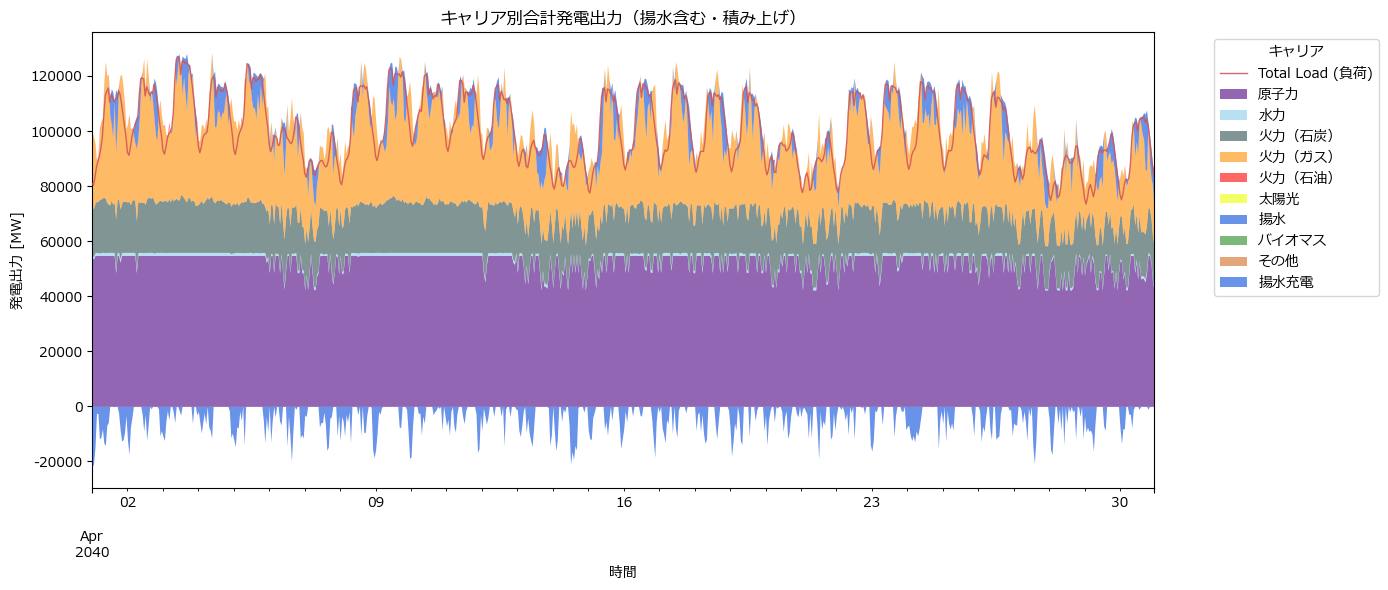


年次: 2050年の最適化を開始


INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
最適化を実行中... (需要変化率: 30%)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 13.33it/s]
INFO:linopy.io: Writing time: 5.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 244825 primals, 870084 duals
Objective: 4.99e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance, Link-ramp_limit_up, Link-ramp_limit_down were not assigned to the network.


✓ 2050年の最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2050.nc contains: generators, buses, loads, carriers, links, sub_networks, stores
c:\Users\takashi-yanase\AppData\Local\miniconda3\envs\pypsa_tepsco\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



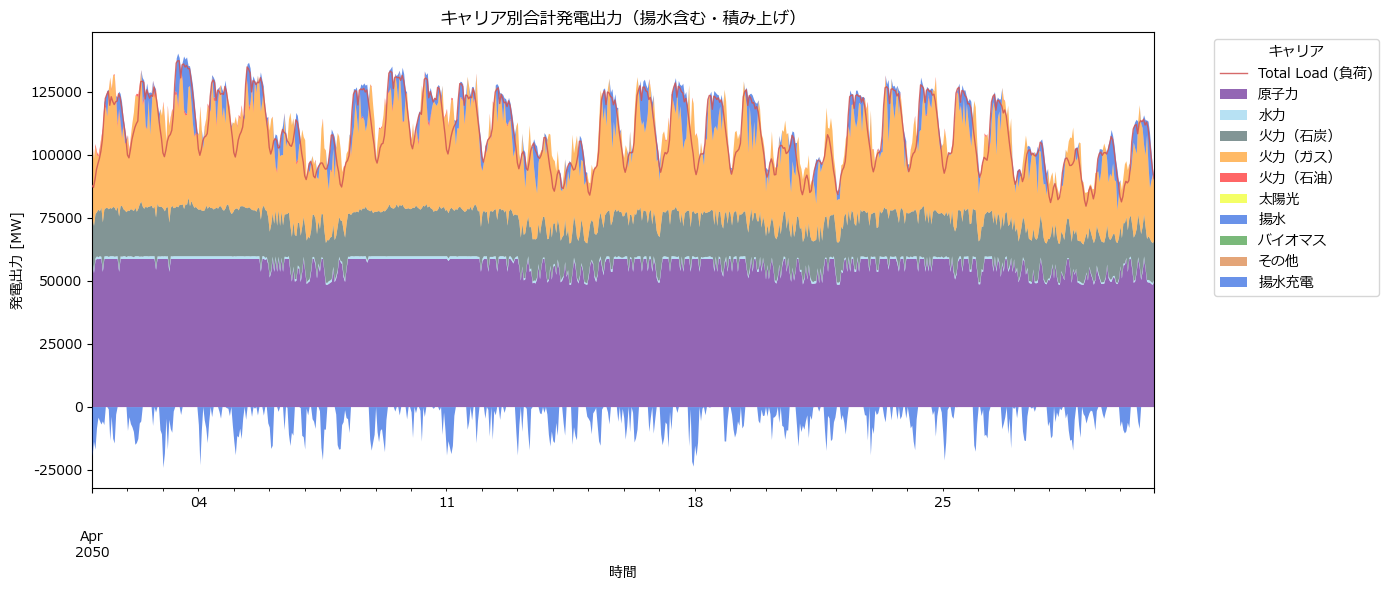


全年次の最適化が完了しました！

結果サマリー:
        total_cost  total_demand
2024  2.002460e+11  6.007908e+07
2030  4.026751e+11  6.608699e+07
2040  4.503935e+11  7.209490e+07
2050  4.987880e+11  7.810280e+07


In [6]:
from linopy import Model

# 複数年断面での最適電源構成計算
import pypsa, os, sys, importlib, shutil, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt

# モジュールインポート（既にインポートされている場合はスキップ）
sys.path.append(os.getcwd())
import src.preprocess_data as preprocess_data
import src.analyze_results as analyze_results

importlib.reload(preprocess_data)
importlib.reload(analyze_results)
warnings.filterwarnings("ignore", category=UserWarning, module="pypsa")

# 出力ディレクトリ作成
os.makedirs('complete_network', exist_ok=True)
os.makedirs('combined_plots', exist_ok=True)

# 分析対象年のリスト
analysis_years = [2024, 2030, 2040, 2050]

# 各年の需要変化率（2024年比）
demand_changes = {
    2024: 0,
    2030: 10,
    2040: 20,
    2050: 30
}

file_name = "./data/raw/pypsa-japan-10BusModelV5.xlsx"

# Ramp制約追加関数
def add_ramp_constraints(n, snapshots):
    
    if hasattr(n, 'links') and len(n.links) > 0:
        links_with_ramp_up = n.links[n.links['ramp_limit_up'].notna() & (n.links['ramp_limit_up'] > 0)].index
        if len(links_with_ramp_up) > 0:
            p_diff = n.model["Link-p"].diff("snapshot")
            ramp_up_limit = n.links.loc[links_with_ramp_up, 'ramp_limit_up'] * n.links.loc[links_with_ramp_up, 'p_nom']
            n.model.add_constraints(p_diff.loc[:, links_with_ramp_up] <= ramp_up_limit, name="Link-ramp_limit_up")
        
        links_with_ramp_down = n.links[n.links['ramp_limit_down'].notna() & (n.links['ramp_limit_down'] > 0)].index
        if len(links_with_ramp_down) > 0:
            p_diff = n.model["Link-p"].diff("snapshot")
            ramp_down_limit = n.links.loc[links_with_ramp_down, 'ramp_limit_down'] * n.links.loc[links_with_ramp_down, 'p_nom']
            n.model.add_constraints(-p_diff.loc[:, links_with_ramp_down] <= ramp_down_limit, name="Link-ramp_limit_down")

# 各年について最適化実行
results_summary = {}

for year in analysis_years:
    print(f"\n{'='*60}")
    print(f"年次: {year}年の最適化を開始")
    print(f"{'='*60}")
    
    # スナップショット作成
    snapshots = pd.date_range(f"{year}-04-01 00:00", f"{year}-04-30 23:00", freq="h")
    snapshots = snapshots[~((snapshots.month == 2) & (snapshots.day == 29))]
    
    # ネットワーク読み込み
    network = pypsa.Network(file_name)
    network.set_snapshots(snapshots)
    
    # 需要データ読み込み
    demand_change = demand_changes.get(year, 0)
    preprocess_data.import_demand_data_from_network_file(network, file_name, demand_change)
    
    # 太陽光データ読み込み
    solar_data_file = './data/processed/solar_time_series.csv'
    preprocess_data.SolarTimeSeriesDataSet(network, solar_data_file)
    
    # 最適化実行
    print(f"最適化を実行中... (需要変化率: {demand_change}%)")
    network.optimize(solver_name='highs', extra_functionality=add_ramp_constraints)
    print(f"✓ {year}年の最適化が完了しました。")
    
    # 結果保存
    network.export_to_netcdf(f'complete_network/optimized_network_{year}.nc')
    
    # 結果サマリー保存
    results_summary[year] = {
        'total_cost': network.objective,
        'total_demand': network.loads_t.p.sum().sum()
    }
    
    # 発電量プロット
    analyze_results.plot_total_generation_by_carrier(network)

print(f"\n{'='*60}")
print("全年次の最適化が完了しました！")
print(f"{'='*60}")

# 結果サマリー表示
summary_df = pd.DataFrame(results_summary).T
print("\n結果サマリー:")
print(summary_df)

# 最初に実行するコード

In [10]:
# モジュールを強制的にリロード
import importlib
import src.preprocess_data as preprocess_data
importlib.reload(preprocess_data)


Year_of_analysis = 2024

file_name = './data/raw/pypsa-japan-10BusModelV3.xlsx'
output_file = './data/processed/solar_time_series.csv'

# 太陽光発電データを取得してCSV保存(一度きり実行)
# Renewable Ninja API Key（取得方法: https://www.renewables.ninja/register）
renewable_ninja_api_key = "0ee68c7853037dcd2235f771d349d104e68996cf"  # ここにAPIキーを入力してください
preprocess_data.GetSolarTimeSeriesData(file_name, output_file, Year_of_analysis, renewable_ninja_api_key)


carrier='AC'のバスに絞り込みました: 9個
取得したバス数: 9
        lat     lon
name               
北海道   43.07  141.40
東北    38.28  140.91
東京    35.67  139.82
中部    35.18  137.01
北陸    36.70  137.22
関西    34.73  135.95
中国    34.39  132.46
四国    34.35  134.05
九州    33.58  130.41
Fetching data for 北海道 (lat: 43.07, lon: 141.4)...
  ✓ Success for 北海道
Fetching data for 東北 (lat: 38.28, lon: 140.91)...
  ✗ Failed for 東北: 429
Fetching data for 東京 (lat: 35.67, lon: 139.82)...
  ✗ Failed for 東京: 429
Fetching data for 中部 (lat: 35.18, lon: 137.01)...
  ✗ Failed for 中部: 429
Fetching data for 北陸 (lat: 36.7, lon: 137.22)...
  ✗ Failed for 北陸: 429
Fetching data for 関西 (lat: 34.73, lon: 135.95)...
  ✗ Failed for 関西: 429
Fetching data for 中国 (lat: 34.39, lon: 132.46)...
  ✗ Failed for 中国: 429
Fetching data for 四国 (lat: 34.35, lon: 134.05)...
  ✗ Failed for 四国: 429
Fetching data for 九州 (lat: 33.58, lon: 130.41)...
  ✗ Failed for 九州: 429

年間太陽光データ(PyPSA形式)を保存しました: ./data/processed/solar_time_series.csv
データサイズ: (8784, 9)

最初の

# メイン（データの読み込み⇒計算）

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
最適化を開始します...
Ramp制約を追加中...


INFO:linopy.model: Solve problem using Highs solver


  ✓ Ramp up制約を追加: 50個のリンク
  ✓ Ramp down制約を追加: 50個のリンク


INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]
INFO:linopy.io: Writing time: 4.78s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 244800 primals, 870060 duals
Objective: 4.93e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance, Link-ramp_limit_up, Link-ramp_limit_down were not assigned to the network.


最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2024.nc contains: generators, buses, loads, carriers, links, sub_networks, stores
c:\Users\takashi-yanase\AppData\Local\miniconda3\envs\pypsa_tepsco\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



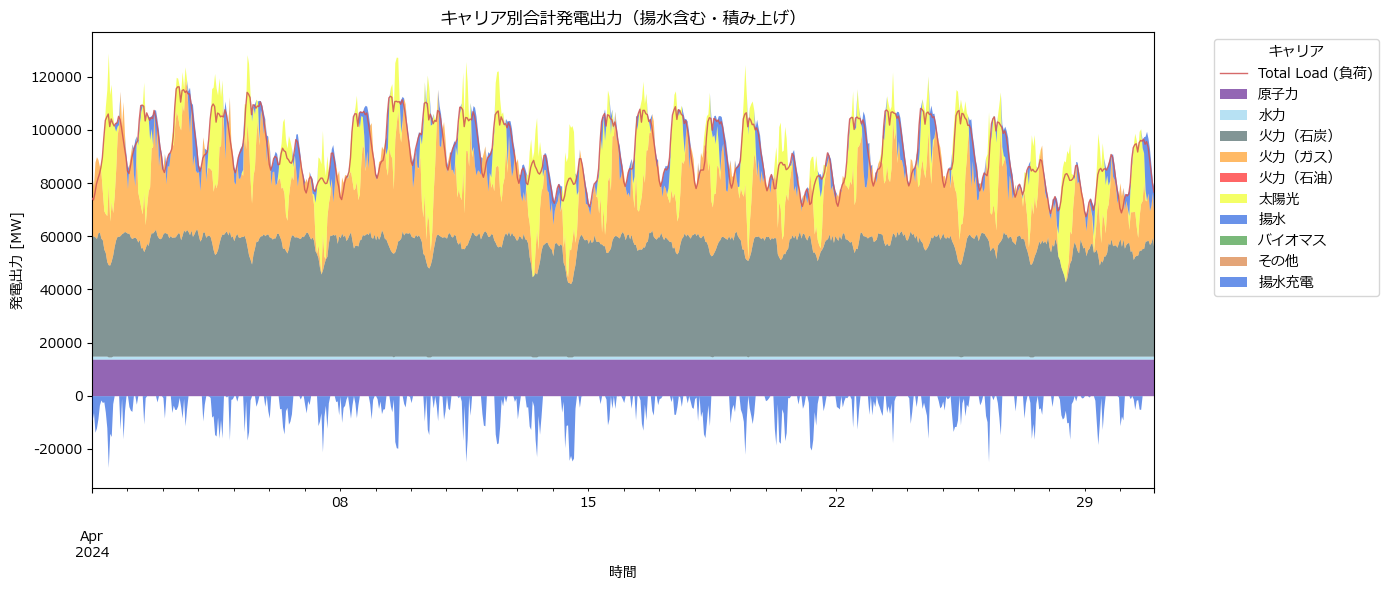

In [12]:
%reset -f
import pypsa, os, sys, importlib, shutil, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.getcwd())

# モジュールを強制的にリロード
import src.preprocess_data as preprocess_data
import src.analyze_results as analyze_results

importlib.reload(preprocess_data)
importlib.reload(analyze_results)
warnings.filterwarnings("ignore", category=UserWarning, module="pypsa")
# pandasの表示設定
pd.set_option('display.max_columns', None)
os.makedirs('complete_network', exist_ok=True)
os.makedirs('combined_plots', exist_ok=True)

Year_of_analysis = 2024
demand_change_compared_to_2024 = 10  # %
file_name = "./data/raw/pypsa-japan-10BusModelV5.xlsx"  # ネットワーク＋需要データを含むExcelファイル

# スナップショット作成
snapshots = pd.date_range(f"{Year_of_analysis}-04-01 00:00",
                          f"{Year_of_analysis}-04-30 23:00",
                          freq="h")
snapshots = snapshots[~((snapshots.month == 2) & (snapshots.day == 29))]

# ネットワークデータ読み込み
network = pypsa.Network(file_name)
network.set_snapshots(snapshots)

# 需要データ読み込み（同じExcelファイルの'Demand'シートから）
preprocess_data.import_demand_data_from_network_file(network, file_name, demand_change_compared_to_2024)

# 太陽光時系列データの読み込み
solar_data_file = './data/processed/solar_time_series.csv'
preprocess_data.SolarTimeSeriesDataSet(network, solar_data_file)

# Ramp制約を追加する関数（PyPSA v1.0以降）
def add_ramp_constraints(n, snapshots):
    """
    Ramp制約を最適化モデルに追加
    - ramp_limit_up: 出力増加率の制限（p_nomに対する比率）
    - ramp_limit_down: 出力減少率の制限（p_nomに対する比率）
    """
    from linopy import Model
    


    # Linkコンポーネントに対するRamp制約
    if hasattr(n, 'links') and len(n.links) > 0:
        # ramp_limit_upが設定されているリンクを抽出
        links_with_ramp_up = n.links[n.links['ramp_limit_up'].notna() & (n.links['ramp_limit_up'] > 0)].index
        if len(links_with_ramp_up) > 0:
            # 出力の時間差分を計算
            p_diff = n.model["Link-p"].diff("snapshot")
            # Ramp up制約: p(t) - p(t-1) <= ramp_limit_up * p_nom
            ramp_up_limit = n.links.loc[links_with_ramp_up, 'ramp_limit_up'] * n.links.loc[links_with_ramp_up, 'p_nom']
            n.model.add_constraints(
                p_diff.loc[:, links_with_ramp_up] <= ramp_up_limit,
                name="Link-ramp_limit_up"
            )
            print(f"  ✓ Ramp up制約を追加: {len(links_with_ramp_up)}個のリンク")
        
        # ramp_limit_downが設定されているリンクを抽出
        links_with_ramp_down = n.links[n.links['ramp_limit_down'].notna() & (n.links['ramp_limit_down'] > 0)].index
        if len(links_with_ramp_down) > 0:
            p_diff = n.model["Link-p"].diff("snapshot")
            # Ramp down制約: p(t-1) - p(t) <= ramp_limit_down * p_nom
            # つまり: -p_diff <= ramp_limit_down * p_nom
            ramp_down_limit = n.links.loc[links_with_ramp_down, 'ramp_limit_down'] * n.links.loc[links_with_ramp_down, 'p_nom']
            n.model.add_constraints(
                -p_diff.loc[:, links_with_ramp_down] <= ramp_down_limit,
                name="Link-ramp_limit_down"
            )
            print(f"  ✓ Ramp down制約を追加: {len(links_with_ramp_down)}個のリンク")

# 最適化実行（Ramp制約を有効化）
print("最適化を開始します...")
print("Ramp制約を追加中...")
network.optimize(
    solver_name='highs',
    extra_functionality=add_ramp_constraints
)
print("最適化が完了しました。")

# ネットワークデータ保存
network.export_to_netcdf(f'complete_network/optimized_network_{Year_of_analysis}.nc')

# 発電量集計・プロット
analyze_results.plot_total_generation_by_carrier(network)